In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['hour'] = train['datetime'].dt.hour
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 16)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 13)

In [6]:
categorical_feature_names = ['season','holiday','workingday',
                            'weather','dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [7]:
feature_names = ['season','weather','temp','atemp','humidity',
                'year','hour','dayofweek','holiday','workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [10]:
X_train = train[feature_names]
X_train.head()

,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


In [11]:
X_test = test[feature_names]
X_test.head()

,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,2011,0,3,0,1
1,1,1,10.66,13.635,56,2011,1,3,0,1
2,1,1,10.66,13.635,56,2011,2,3,0,1
3,1,1,10.66,12.880,56,2011,3,3,0,1
4,1,1,10.66,12.880,56,2011,4,3,0,1


In [12]:
label_name = 'count'

y_train = train[label_name]

y_train.head()

0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

In [13]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [17]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

lModel = LinearRegression()
y_train_log = np.log1p(y_train)
lModel.fit(X_train, y_train_log)

preds = lModel.predict(X_train)
print(rmsle(np.exp(y_train_log), np.exp(preds)))

0.9803697923313504


In [19]:
ridge_m_ = Ridge()
ridge_params_ = {'max_iter':[3000],'alpha':[0.01,0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}
ridge_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV(ridge_m_,
                           ridge_params_,
                           scoring=rmsle_scorer,
                           cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X_train, y_train_log)
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

{'alpha': 1000, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9819438728547794


In [28]:
df = pd.DataFrame(grid_ridge_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232174
1,0.10,0.232174
2,1.00,0.232176
3,2.00,0.232177
4,3.00,0.232179


In [26]:
ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.01, 0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
grid_ridge_m.fit( X_train, y_train_log )
preds = grid_ridge_m.predict(X_train)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

{'alpha': 0.01, 'max_iter': 3000}
RMSLE Value For Ridge Regression:  0.9803697902780806


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015194,0.004713,0.005405,0.001498,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-0.269563,-0.208115,-0.253182,-0.222773,-0.207235,-0.232174,0.025014,1
1,0.007808,0.000747,0.003992,0.001089,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-0.269565,-0.208115,-0.253182,-0.222773,-0.207234,-0.232174,0.025014,2
2,0.008998,0.001553,0.002997,0.000002,1,3000,"{'alpha': 1, 'max_iter': 3000}",-0.269576,-0.208120,-0.253181,-0.222769,-0.207231,-0.232176,0.025018,3
3,0.013012,0.005380,0.004588,0.001856,2,3000,"{'alpha': 2, 'max_iter': 3000}",-0.269589,-0.208125,-0.253180,-0.222765,-0.207227,-0.232177,0.025021,4
4,0.013801,0.000402,0.005399,0.003382,3,3000,"{'alpha': 3, 'max_iter': 3000}",-0.269602,-0.208130,-0.253179,-0.222761,-0.207223,-0.232179,0.025025,5


In [27]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.232174
1,0.10,0.232174
2,1.00,0.232176
3,2.00,0.232177
4,3.00,0.232179


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

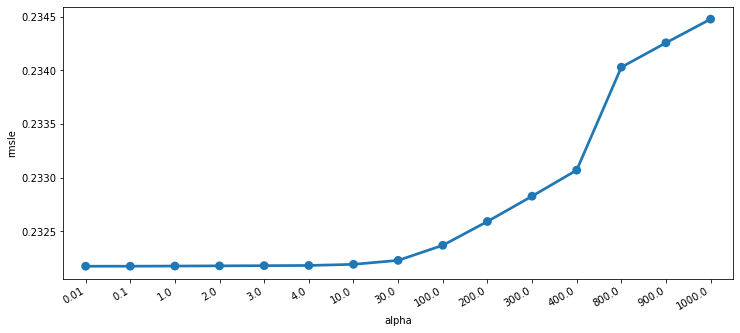

In [29]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [32]:
lasso_m_ = Lasso()
alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter':[3000],'alpha':alpha}

grid_lasso_m_ = GridSearchCV(lasso_m_, lasso_params_, scoring=rmsle_scorer, cv=5)
y_train_log = np.log1p(y_train)
grid_lasso_m_.fit( X_train, y_train_log )

preds = grid_lasso_m_.predict(X_train)
print (grid_lasso_m_.best_params_)
print ("RMSLE Value For lasso Regression: ", rmsle(np.exp(y_train_log),np.exp(preds)))

df = pd.DataFrame(grid_lasso_m_.cv_results_)
df.head()

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For lasso Regression:  0.9803736954998871


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015403,0.003612,0.005799,0.001944,10,3000,"{'alpha': 10.0, 'max_iter': 3000}",-0.396253,-0.281136,-0.336539,-0.293402,-0.279405,-0.317347,0.044539,14
1,0.010797,0.002043,0.003798,0.000979,1,3000,"{'alpha': 1.0, 'max_iter': 3000}",-0.328275,-0.225212,-0.260999,-0.223852,-0.221538,-0.251975,0.040833,13
2,0.012200,0.001166,0.003401,0.000800,0.5,3000,"{'alpha': 0.5, 'max_iter': 3000}",-0.317931,-0.224863,-0.256118,-0.220462,-0.219943,-0.247863,0.037515,12
3,0.013994,0.002355,0.004608,0.001024,0.333333,3000,"{'alpha': 0.3333333333333333, 'max_iter': 3000}",-0.314600,-0.225125,-0.254794,-0.219569,-0.219675,-0.246753,0.036354,11
4,0.014390,0.003502,0.004610,0.001025,0.25,3000,"{'alpha': 0.25, 'max_iter': 3000}",-0.312960,-0.225301,-0.254182,-0.219231,-0.219591,-0.246253,0.035757,10


In [33]:
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)

df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,10.000000,0.317347
1,1.000000,0.251975
2,0.500000,0.247863
3,0.333333,0.246753
4,0.250000,0.246253


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

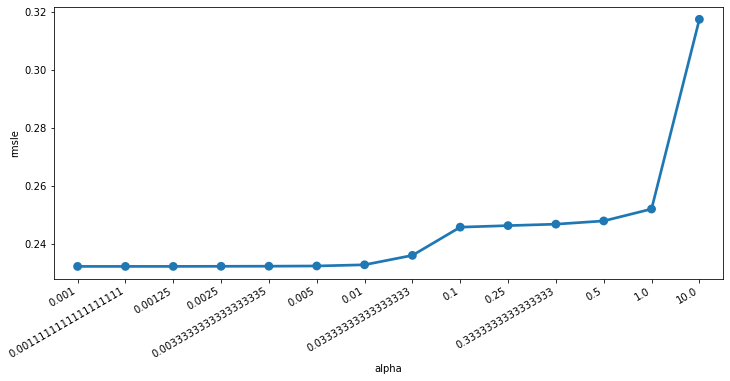

In [34]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

In [36]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

preds = rfModel.predict(X_train)
print ("RMSLE Value For RandomForest: ", rmsle(np.exp(y_train_log),np.exp(preds)))

RMSLE Value For RandomForest:  0.10693998698978507


In [37]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01);

y_train_log = np.log1p(y_train)
gbm.fit(X_train, y_train_log)

preds = gbm.predict(X_train)
print ("RMSLE Value For Gradient Boost: ", rmsle(np.exp(y_train_log),np.exp(preds)))

RMSLE Value For Gradient Boost:  0.2135740372784033


<AxesSubplot:ylabel='Density'>

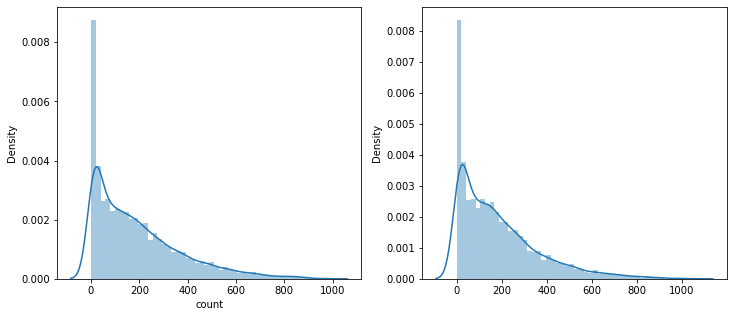

In [38]:
predsTest = gbm.predict(X_test)
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train,ax=ax1,bins=50)
sns.distplot(np.exp(predsTest),ax=ax2,bins=50)

In [40]:
submission = pd.read_csv("sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.227543
1,2011-01-20 01:00:00,6.296610
2,2011-01-20 02:00:00,4.259238
3,2011-01-20 03:00:00,2.666615
4,2011-01-20 04:00:00,2.295918


In [42]:
submission.to_csv(f"submission.csv", index=False)